In [41]:
import os
import json
import contextlib

import sqlalchemy as sa
from sqlalchemy.orm import sessionmaker

import pandas as pd
import numpy as np

import re
import urllib.parse

import matplotlib.pyplot as plt

In [42]:
from html import unescape
import unicodedata

In [43]:
import spacy
from spacy.language import Language

from spacy_language_detection import LanguageDetector

In [44]:
CONFIG_PATH = "config.json"
OUT_FILE = "traintest.pq"
VERBOSE = False

In [45]:
CONFIG = None
ENGINES = {}
TABLES = {}
BINDS = {}
SESSION = None


def config_template():
    default_conn = {
        "dialect": "postgresql",
        "host": "localhost",
        "port": 5432,
        "dbname": "INVALID",
        "schema": "public",
        "user": "INVALID",
        "passwd": "INVALID",
    }
    return {
        "dbs": {
            "login": default_conn.copy(),
            "sm": default_conn.copy(),
            "exp": default_conn.copy(),
            "ap": default_conn.copy(),
            "blogs": default_conn.copy(),
        }
    }


def get_config():
    global CONFIG
    
    if CONFIG is not None:
        return CONFIG
    if not os.path.exists(CONFIG_PATH):
        with open(CONFIG_PATH, "w") as fout:
            print(json.dumps(config_template(), indent=4, sort_keys=True), file=fout)
        raise ValueError(
            f"config file missing. new file was created at '{CONFIG_PATH}'. "
            "please correct values in file and run again")
    with open(CONFIG_PATH, "r") as fin:
        CONFIG = json.load(fin)
    config_out = {
        "dbs": {
            "login": CONFIG["dbs"]["login"].copy(),
            "sm": CONFIG["dbs"]["sm"].copy(),
            "exp": CONFIG["dbs"]["exp"].copy(),
            "ap": CONFIG["dbs"]["ap"].copy(),
            "blogs": CONFIG["dbs"]["blogs"].copy(),
        }
    }
    config_out["dbs"]["login"]["passwd"] = "..."
    config_out["dbs"]["sm"]["passwd"] = "..."
    config_out["dbs"]["exp"]["passwd"] = "..."
    config_out["dbs"]["ap"]["passwd"] = "..."
    print(f"loaded config\n{json.dumps(config_out, indent=2, sort_keys=True)}")
    return CONFIG


def get_engine(dbname):
    res = ENGINES.get(dbname)
    if res is not None:
        return res
    db = get_config()["dbs"][dbname]
    user = urllib.parse.quote_plus(db["user"])
    passwd = urllib.parse.quote_plus(db["passwd"])
    engine = sa.create_engine(
        f"{db['dialect']}://{user}:{passwd}@{db['host']}:{db['port']}/{db['dbname']}",
        echo=VERBOSE)
    engine = engine.execution_options(
        schema_translate_map={None: db['schema']})
    res = engine, sa.MetaData()
    ENGINES[dbname] = res
    return res


def get_table(dbname, tablename):
    global SESSION
    
    key = (dbname, tablename)
    res = TABLES.get(key)
    if res is not None:
        return res
    SESSION = None
    engine, metadata = get_engine(dbname)
    res = sa.Table(
        tablename,
        metadata,
        autoload_with=engine)
    TABLES[key] = res
    BINDS[res] = engine
    return res


@contextlib.contextmanager
def get_session():
    global SESSION
    
    session = SESSION
    if session is None:
        session = sessionmaker()
        session.configure(binds=BINDS)
        SESSION = session
    with session() as res:
        yield res

In [46]:
def clean(text: str) -> str:
    text = text.strip()
    while True:
        prev_text = text
        text = unescape(text)
        if prev_text == text:
            break
    text = unicodedata.normalize("NFKC", text)
    return re.sub("\n\n\n+", "\n\n", re.sub("[ \t]+", " ", re.sub("\n[ \t]+", "\n", re.sub("\n\n+", "\n", re.sub("\r", "\n", text)))))

def strip_html(text: str) -> str:
    return re.sub(r"<(?:\"[^\"]*\"['\"]*|'[^']*'['\"]*|[^'\">])+>", "", re.sub(r"<br\s*/?\s*>", "\n", text.strip()))

In [47]:
strip_html("abc<b>def<br>ghi<a href=\"foo\" c =  '1    2   3   '      >foo<br / >bar</b>lm<   /   a >")

'abcdef\nghifoo\nbarlm'

In [48]:
# global tables
t_tags = get_table("login", "tags")
t_users = get_table("login", "users")

# solution mapping tables
t_sm_pads = get_table("sm", "pads")
t_sm_tagging = get_table("sm", "tagging")

# action plan tables
t_ap_pads = get_table("ap", "pads")
t_ap_tagging = get_table("ap", "tagging")

# experiments tables
t_exp_pads = get_table("exp", "pads")
t_exp_tagging = get_table("exp", "tagging")

loaded config
{
  "dbs": {
    "ap": {
      "dbname": "action_plans_platform",
      "dialect": "postgresql",
      "host": "acclabs-global-login.postgres.database.azure.com",
      "passwd": "...",
      "port": 5432,
      "schema": "public",
      "user": "acclabshqadmin@acclabs-global-login"
    },
    "blogs": {
      "dbname": "blogs",
      "dialect": "postgresql",
      "host": "acclabs.postgres.database.azure.com",
      "passwd": "acclabsblogs@2023",
      "port": 5432,
      "schema": "public",
      "user": "undpacclab@acclabs"
    },
    "exp": {
      "dbname": "experiments_platform",
      "dialect": "postgresql",
      "host": "acclabs-global-login.postgres.database.azure.com",
      "passwd": "...",
      "port": 5432,
      "schema": "public",
      "user": "acclabshqadmin@acclabs-global-login"
    },
    "login": {
      "dbname": "postgres",
      "dialect": "postgresql",
      "host": "acclabs-global-login.postgres.database.azure.com",
      "passwd": "...",
     

/var/folders/ff/zrdw3xx56dd1w9xbl6x_yl0c0000gn/T/ipykernel_26804/3044908452.py:85: SAWarning: Did not recognize type 'ltree' of column 'version'
  res = sa.Table(


In [49]:
with get_session() as session:
    stmt = sa.select(sa.func.count(t_sm_pads.c.id))
    stmt = stmt.where(t_sm_pads.c.status >= 2)
    sm_pad_count = int(session.execute(stmt).one()[0])
    print(sm_pad_count)

3366


In [50]:
with get_session() as session:
    stmt = sa.select(sa.func.count(t_ap_pads.c.id))
    stmt = stmt.where(t_ap_pads.c.status >= 2)
    ap_pad_count = int(session.execute(stmt).one()[0])
    print(ap_pad_count)

873


In [51]:
with get_session() as session:
    stmt = sa.select(sa.func.count(t_exp_pads.c.id))
    stmt = stmt.where(t_exp_pads.c.status >= 2)
    exp_pad_count = int(session.execute(stmt).one()[0])
    print(exp_pad_count)

208


In [52]:
tags = {}
with get_session() as session:
    stmt = sa.select(t_tags.c.id, t_tags.c.name, t_tags.c.type)
    for row in session.execute(stmt):
        tags[row[0]] = (row[1], row[2])

In [53]:
pad_stats = {
    "db": [],
    "status": [],
    "content-length": [],
    "id": [],
}
with get_session() as session:
    for (name, pad_db) in [("sm", t_sm_pads), ("ap", t_ap_pads), ("exp", t_exp_pads)]:
        stmt = sa.select(pad_db.c.status, pad_db.c.full_text, pad_db.c.id)
        for row in session.execute(stmt):
            pad_stats["db"].append(name)
            pad_stats["status"].append(int(row[0]))
            pad_stats["content-length"].append(len(row[1]) if row[1] is not None else 0)
            pad_stats["id"].append(row[2])
pad_stats_df = pd.DataFrame(pad_stats)
pad_stats_df

,db,status,content-length,id
0,sm,3,508,4357
1,sm,3,880,4364
2,sm,0,169,1686
3,sm,3,3090,4571
4,sm,2,980,6099
...,...,...,...,...
5626,exp,2,4615,235
5627,exp,0,454,237
5628,exp,0,8888,241
5629,exp,2,9413,252


array([[<AxesSubplot: title={'center': 'ap'}>,
        <AxesSubplot: title={'center': 'exp'}>],
       [<AxesSubplot: title={'center': 'sm'}>, <AxesSubplot: >]],
      dtype=object)

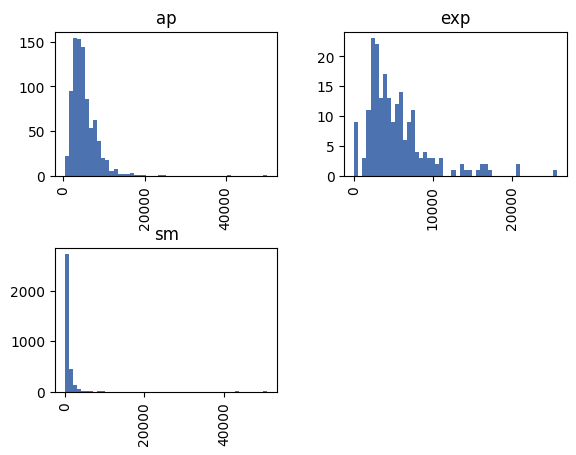

In [54]:
pub_db = pad_stats_df[pad_stats_df["status"] >= 2]
pub_db.hist("content-length", bins=50, by="db")

array([[<AxesSubplot: title={'center': 'ap'}>,
        <AxesSubplot: title={'center': 'exp'}>],
       [<AxesSubplot: title={'center': 'sm'}>, <AxesSubplot: >]],
      dtype=object)

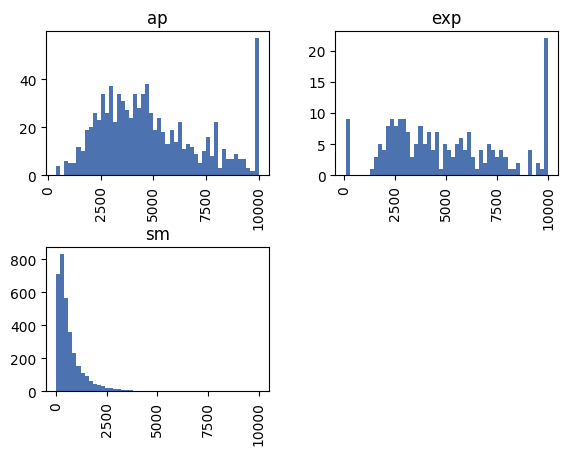

In [55]:
pub_db_clip = pub_db.copy()
pub_db_clip["content-length"].clip(0, 10000, inplace=True)
pub_db_clip.hist("content-length", bins=50, by="db")
# plt.hist([
#     pub_db[pub_db["db"] == "ap"]["content-length"].clip(0, 10000),
#     pub_db[pub_db["db"] == "exp"]["content-length"].clip(0, 10000),
#     pub_db[pub_db["db"] == "sm"]["content-length"].clip(0, 10000),
# ], label=["ap", "exp", "sm"])
# plt.legend(loc='upper right')
# plt.show()

In [56]:
pub_db.groupby("db")["content-length"].describe()

,count,mean,std,min,25%,50%,75%,max
db,,,,,,,,
ap,873.0,5168.193585,3518.645532,389.0,3040.00,4500.0,6396.0,50240.0
exp,208.0,5440.865385,4008.137205,69.0,2795.25,4444.5,6928.0,25735.0
sm,3366.0,728.639632,1371.521881,19.0,253.00,466.0,856.0,50893.0


In [57]:
pub_db.groupby("db")["content-length"].median()

db
ap     4500.0
exp    4444.5
sm      466.0
Name: content-length, dtype: float64

In [65]:
pub_db[(pub_db["db"] == "sm") & (pub_db["content-length"] > 856)]

,db,status,content-length,id
1,sm,3,880,4364
3,sm,3,3090,4571
4,sm,2,980,6099
6,sm,2,993,6100
8,sm,3,2896,4939
...,...,...,...,...
4258,sm,3,5125,5870
4286,sm,2,2166,5957
4287,sm,2,50893,5966
4291,sm,2,1903,5977


In [78]:
th = 856
print("\n".join([f"longest above {th} length"] + [
    f"https://acclabs-solutionsmapping.azurewebsites.net/en/view/pad?id={row['id']}"
    for _, row in pub_db[(pub_db["db"] == "sm") & (pub_db["content-length"] > th)].sort_values("content-length").tail(20).iterrows()
] + [""] + [f"shortest above {th} length"] + [
    f"https://acclabs-solutionsmapping.azurewebsites.net/en/view/pad?id={row['id']}"
    for _, row in pub_db[(pub_db["db"] == "sm") & (pub_db["content-length"] > th)].sort_values("content-length").head(20).iterrows()
]))

longest above 856 length
https://acclabs-solutionsmapping.azurewebsites.net/en/view/pad?id=5849
https://acclabs-solutionsmapping.azurewebsites.net/en/view/pad?id=5408
https://acclabs-solutionsmapping.azurewebsites.net/en/view/pad?id=4329
https://acclabs-solutionsmapping.azurewebsites.net/en/view/pad?id=2968
https://acclabs-solutionsmapping.azurewebsites.net/en/view/pad?id=4564
https://acclabs-solutionsmapping.azurewebsites.net/en/view/pad?id=5870
https://acclabs-solutionsmapping.azurewebsites.net/en/view/pad?id=921
https://acclabs-solutionsmapping.azurewebsites.net/en/view/pad?id=5759
https://acclabs-solutionsmapping.azurewebsites.net/en/view/pad?id=5867
https://acclabs-solutionsmapping.azurewebsites.net/en/view/pad?id=5854
https://acclabs-solutionsmapping.azurewebsites.net/en/view/pad?id=4384
https://acclabs-solutionsmapping.azurewebsites.net/en/view/pad?id=5713
https://acclabs-solutionsmapping.azurewebsites.net/en/view/pad?id=4961
https://acclabs-solutionsmapping.azurewebsites.net/en

In [13]:
def get_lang_detector(nlp, name):
    return LanguageDetector(seed=42)

spacy_nlp_model = spacy.load("en_core_web_sm")
Language.factory("language_detector", func=get_lang_detector)
spacy_nlp_model.add_pipe("language_detector", last=True)

def get_lang(doc):
    max_len = 1000000
    if len(doc) > max_len:
        doc = doc[:max_len]
        doc = doc[:doc.rfind(" ")]
    mdoc = spacy_nlp_model(doc)
    return mdoc._.language

In [14]:
with get_session() as session:
    stmt = sa.select(t_sm_pads.c.id, t_sm_pads.c.title, t_sm_pads.c.sections, t_sm_pads.c.full_text, t_sm_pads.c.owner)
    stmt = stmt.where(t_sm_pads.c.status >= 2)
    stmt = stmt.limit(3)
    for row in session.execute(stmt):
        ftext = clean(strip_html(row[3]))
        print("=TITLE=================")
        print(clean(row[1]))
        print("=TEXT==================")
        print(ftext)
        print("=TAGS==================")
        tstmt = sa.select(t_sm_tagging.c.tag_id)
        tstmt = tstmt.where(t_sm_tagging.c.pad == row[0])
        for tag in session.execute(tstmt):
            t_name, t_type = tags[tag[0]]
            if t_type == "thematic_areas":
                print(t_name)
        print("=COUNTRY===============")
        owner_uuid = row[4]
        cstmt = sa.select(t_users.c.iso3).where(t_users.c.uuid == owner_uuid)
        print(session.execute(cstmt).scalar_one())
        print("=LANGUAGE==============")
        print(get_lang(ftext))
        print()

=TITLE=================
The power of faith facing of the weakness of the means of a young self-taught innovator
=TEXT==================
The power of faith facing of the weakness of the means of a young self-taught innovator
Mamadou Saliou Diallo 
Whatsapp Via Moussa CAMARA +224624976073
NO
In a village where everyone thinks that not going far in their studies is an end in itself, where relentlessness and dedication are not considered as real arguments to support a citizen in his project, this is the decor in which evolves Mamadou Saliou Diallo, an autodidact whose level of study is of the 5th year of primary school; is developing a pico-dam to supply electricity to surrounding villages.
In the process of developing the energy sector to solve the power problem in Guinea, the government has electrified major cities, prefectures, and sub-prefectures. However, it emerges that despite these enormous efforts, shortcomings remain. So to provide a quick and low-cost solution, our friend “Actor

In [15]:
sm_tag_counts = {}
with get_session() as session:
    stmt = sa.select(t_sm_tagging.c.tag_id, sa.func.count(t_sm_tagging.c.tag_id))
    stmt = stmt.group_by(t_sm_tagging.c.tag_id).order_by(sa.func.count(t_sm_tagging.c.tag_id).desc())
    for theme in [True, False]:
        print_count = 10
        for row in session.execute(stmt):
            t_name, t_type = tags[row[0]]
            if (t_type == "thematic_areas") != theme:
                continue
            if print_count > 0:
                print(f"{row[1] / sm_pad_count * 100.0:.2f}% {row[1]} {t_name} ({t_type})")
                print_count -= 1
            sm_tag_counts[t_name] = int(row[1])
        print()

8.87% 283 circular economy (thematic_areas)
7.37% 235 agriculture (thematic_areas)
6.27% 200 waste management (thematic_areas)
6.24% 199 covid-19 response (thematic_areas)
5.64% 180 innovation (thematic_areas)
5.30% 169 health (thematic_areas)
4.83% 154 recycling (thematic_areas)
4.74% 151 environment friendly (thematic_areas)
4.48% 143 youth (thematic_areas)
4.45% 142 entrepreneurship (thematic_areas)

38.07% 1214 Sustainable cities and communities (sdgs)
32.52% 1037 Responsible consumption and production (sdgs)
26.72% 852 Decent work and economic growth (sdgs)
26.72% 852 Industry, innovation and infrastructure (sdgs)
24.96% 796 Climate action (sdgs)
23.02% 734 Good health and well-being (sdgs)
16.62% 530 Affordable and clean energy (sdgs)
15.24% 486 No poverty (sdgs)
14.21% 453 Zero hunger (sdgs)
13.26% 423 Reduced innequalities (sdgs)



In [16]:
ap_tag_counts = {}
with get_session() as session:
    stmt = sa.select(t_ap_tagging.c.tag_id, sa.func.count(t_ap_tagging.c.tag_id))
    stmt = stmt.group_by(t_ap_tagging.c.tag_id).order_by(sa.func.count(t_ap_tagging.c.tag_id).desc())
    for theme in [True, False]:
        print_count = 10
        for row in session.execute(stmt):
            t_name, t_type = tags[row[0]]
            if (t_type == "thematic_areas") != theme:
                continue
            if print_count > 0:
                print(f"{row[1] / ap_pad_count * 100.0:.2f}% {row[1]} {t_name} ({t_type})")
                print_count -= 1
            ap_tag_counts[t_name] = int(row[1])
        print()

4.40% 38 circular economy (thematic_areas)
3.71% 32 waste management (thematic_areas)
3.48% 30 co-creation (thematic_areas)
3.24% 28 behavioral insights (thematic_areas)
3.24% 28 community empowerment (thematic_areas)
3.13% 27 digital transformation (thematic_areas)
3.13% 27 climate change (thematic_areas)
3.13% 27 youth and unemployment (thematic_areas)
3.01% 26 public sector innovation (thematic_areas)
2.78% 24 behavioral change (thematic_areas)

41.71% 360 Co-creation (methods)
40.09% 346 Collective Intelligence (methods)
34.41% 297 Solutions Mapping (methods)
30.36% 262 focus group (datasources)
27.93% 241 Prototyping (methods)
27.35% 236 surveys (datasources)
26.88% 232 System Thinking (methods)
26.77% 231 Decent work and economic growth (sdgs)
25.96% 224 Sensemaking (methods)
25.72% 222 direct interviews (datasources)



In [17]:
exp_tag_counts = {}
with get_session() as session:
    stmt = sa.select(t_exp_tagging.c.tag_id, sa.func.count(t_exp_tagging.c.tag_id))
    stmt = stmt.group_by(t_exp_tagging.c.tag_id).order_by(sa.func.count(t_exp_tagging.c.tag_id).desc())
    for theme in [True, False]:
        print_count = 10
        for row in session.execute(stmt):
            t_name, t_type = tags[row[0]]
            if (t_type == "thematic_areas") != theme:
                continue
            if print_count > 0:
                print(f"{row[1] / exp_pad_count * 100.0:.2f}% {row[1]} {t_name} ({t_type})")
                print_count -= 1
            exp_tag_counts[t_name] = int(row[1])
        print()

10.89% 22 waste management (thematic_areas)
6.44% 13 behavioral insights (thematic_areas)
4.95% 10 access to information (thematic_areas)
3.96% 8 access to basic services (thematic_areas)
3.47% 7 public sector innovation (thematic_areas)
3.47% 7 co-creation (thematic_areas)
2.97% 6 behavioral change (thematic_areas)
2.97% 6 knowledge management (thematic_areas)
2.97% 6 employment (thematic_areas)
2.48% 5 covid-19 response (thematic_areas)

50.99% 103 Sustainable cities and communities (sdgs)
39.60% 80 Partnerships for the goals (sdgs)
37.62% 76 Climate action (sdgs)
32.18% 65 Decent work and economic growth (sdgs)
30.20% 61 Reduced innequalities (sdgs)
26.73% 54 Industry, innovation and infrastructure (sdgs)
20.79% 42 No poverty (sdgs)
20.79% 42 Responsible consumption and production (sdgs)
18.81% 38 Peace, justice and strong institutions (sdgs)
16.34% 33 Good health and well-being (sdgs)



In [18]:
all_tags = [(tid, tname) for (tid, (tname, ttype)) in tags.items() if ttype == "thematic_areas"]
all_tags[:10], all_tags[-10:]

([(736, 'ocean'),
  (747, 'formalising the informal'),
  (757, 'productivity'),
  (1278, 'flooding'),
  (835, 'reducing gender inequalities'),
  (839, 'cooperativism'),
  (842, 'nutrition'),
  (846, 'logistics'),
  (850, 'transportation'),
  (616, 'Acupuntura Urbana')],
 [(4048, 'social innovation platform'),
  (4050, 'adolescents'),
  (4061, 'impact investing'),
  (4201, 'energy efficiency audits'),
  (4203, 'households'),
  (4259, 'digital government'),
  (4204, 'thermal camera'),
  (4261, 'digital payments'),
  (4205, 'residential energy efficiency'),
  (3257, 'epower agregetor')])

In [19]:
rng = np.random.default_rng(42)

In [20]:
train_size = 1000
test_size = 1000
train_test_ixs = list(rng.choice(list(range(sm_pad_count)), train_size + test_size, replace=False))
is_train = set(train_test_ixs[:train_size])
is_test = set(train_test_ixs[train_size:])

In [21]:
content = {
    "id": [],
    "stage": [],
    "db": [],
    "country": [],
    "title": [],
    "text": [],
    "lang": [],
}
ctags = {}
ctagnames = []
for (tag_id, tag_name) in all_tags:
    col_name = f"tag_{tag_name}"
    ctagnames.append(col_name)
    ctags[tag_id] = col_name
    content[col_name] = []
tables = [
    ("sm", t_sm_pads, t_sm_tagging),
    ("ap", t_ap_pads, t_ap_tagging),
    ("exp", t_exp_pads, t_exp_tagging),
]
country_cache = {}
with get_session() as session:
    for (t_name, t_pads, t_tagging) in tables:
        stmt = sa.select(t_pads.c.id, t_pads.c.title, t_pads.c.full_text, t_pads.c.owner)
        stmt = stmt.where(t_pads.c.status >= 2)
        cur_ix = 0
        for row in session.execute(stmt):
            cur_ix += 1
            body = clean(strip_html(row[2]))
            pad_id = row[0]
            info = {"id": f"{pad_id}", "db": f"{t_name}"}
            if len(body) <= 80:
                print(f"short body ({len(body)}). skipping... [{info}]: {body}")
                continue
            if t_name == "sm":
                stage = "validation"
                if cur_ix in is_train:
                    stage = "train"
                if cur_ix in is_test:
                    stage = "test"
            else:
                stage = "validation"
            owner_uuid = row[3]
            country = country_cache.get(owner_uuid)
            if country is None:
                cstmt = sa.select(t_users.c.iso3).where(t_users.c.uuid == owner_uuid)
                country = session.execute(cstmt).scalar_one()
                # print(f"discovered new country: {country}")
                country_cache[owner_uuid] = country
            content["country"].append(country)
            content["id"].append(pad_id)
            content["stage"].append(stage)
            content["db"].append(t_name)
            title = row[1]
            if title is None:
                fallback = body[:body.find("\n")][:80]
                fallback = fallback[:fallback.rfind(" ")]
                title = fallback
                print(f"missing title [{info}]: {title}")
            content["title"].append(clean(title))
            content["text"].append(body)
            lang = get_lang(body)
            if lang["score"] < 0.99:
                shortened = body[:80]
                shortened = shortened[:shortened.rfind(" ")]
                print(f"low confidence language {lang} [{info}]: {shortened}")
            content["lang"].append(lang["language"])
            for cname in ctagnames:
                content[cname].append(False)
            tstmt = sa.select(t_tagging.c.tag_id)
            tstmt = tstmt.where(t_tagging.c.pad == row[0])
            for tag in session.execute(tstmt):
                cname = ctags.get(tag[0])
                if cname is not None:
                    content[cname][-1] = True
df = pd.DataFrame(content, columns=["stage", "id", "db", "country", "lang", "title", "text"] + sorted(ctagnames))
final_tags = []
for cname in ctagnames:
    if df[cname].all() or not df[cname].any():
        print(f"drop {cname}")
        del df[cname]
    else:
        final_tags.append(cname)

short body (55). skipping... [{'id': '5775', 'db': 'sm'}]: Conversion of sugarcane bagasse into pulp and paper bag
low confidence language {'language': 'en', 'score': 0.8571419188776856} [{'id': '4474', 'db': 'sm'}]: Certificates (birth): Welcome New-born
Project Welcome New-Born allows new
short body (43). skipping... [{'id': '3101', 'db': 'sm'}]: Takalidi
E-commerce platform for craftsmen.
low confidence language {'language': 'en', 'score': 0.8571388546508837} [{'id': '3099', 'db': 'sm'}]: maykiHA
A digital platform for crowdfunding. https://maykiha.com/
short body (58). skipping... [{'id': '2209', 'db': 'sm'}]: Agromush Uganda - Ahabwe Canary 
Improved Mushroom farming
short body (37). skipping... [{'id': '2206', 'db': 'sm'}]: Apinet Uganda Ltd-
Edson Twinomugisha
short body (75). skipping... [{'id': '832', 'db': 'sm'}]: Gastrol green power
Deforestation overcome and its long term sided effects.
short body (20). skipping... [{'id': '4768', 'db': 'sm'}]: E-mobility for Quito
short bo

In [22]:
df

,stage,id,db,country,lang,title,text,tag_3d printing,tag_Acupuntura Urbana,tag_Bebidas Tradicionales,...,tag_wood gas,tag_wood stove,tag_woodchips,tag_worker safety,tag_youth,tag_youth activism,tag_youth and unemployment,tag_youth empowerment,tag_youth informality,tag_zero waste
0,validation,5019,sm,GIN,en,The power of faith facing of the weakness of t...,The power of faith facing of the weakness of t...,False,False,False,...,False,False,False,False,False,False,False,True,False,False
1,validation,5164,sm,GIN,en,local three lines power agregetor,local three lines power agregetor\nDIALLO Thie...,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,test,5022,sm,GIN,en,Teflon REGULATOR,Teflon REGULATOR\nThe TEFLON or PTFE is stable...,False,False,False,...,False,False,False,False,False,False,True,False,False,False
3,train,2783,sm,GIN,en,Public Lights auto managed,Public Lights auto managed \nSolution developp...,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,test,5021,sm,GIN,en,ORGANIC WASTE Matanizer !,ORGANIC WASTE Matanizer !\nHere is a Solide wa...,False,False,False,...,False,False,False,False,False,False,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4010,validation,197,exp,LBY,en,Reducing the Use of Single-Use Plastic Bags in...,Reducing the Use of Single-Use Plastic Bags in...,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4011,validation,362,exp,GTM,en,Using DPPD to identify greater indigenous poli...,Using DPPD to identify greater indigenous poli...,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4012,validation,252,exp,PHL,en,"Local Convergence: Promoting Agile, Adaptive, ...","Local Convergence: Promoting Agile, Adaptive, ...",False,False,False,...,False,False,False,False,False,False,False,False,False,False
4013,validation,241,exp,PHL,en,Marine Litter: Behavioral Insights Experiment ...,Marine Litter: Behavioral Insights Experiment ...,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [23]:
show_amount = 50
for cname in final_tags:
    train_cat_count = df.loc[df["stage"] == "train", cname].sum()
    test_cat_count = df.loc[df["stage"] == "test", cname].sum()
    validation_cat_count = df.loc[df["stage"] == "validation", cname].sum()
    text = f"{train_cat_count} {test_cat_count} {validation_cat_count} {cname}"
    if show_amount > 0:
        print(text)
        if not test_cat_count:
            print("^" * len(text))
        show_amount -= 1

7 7 11 tag_ocean
1 1 4 tag_formalising the informal
3 2 10 tag_productivity
3 1 5 tag_flooding
4 0 8 tag_reducing gender inequalities
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
10 7 12 tag_cooperativism
2 1 4 tag_nutrition
1 1 0 tag_logistics
6 9 14 tag_transportation
0 1 0 tag_Acupuntura Urbana
0 1 7 tag_access
8 3 21 tag_gender focus
5 6 16 tag_gender violence
8 6 9 tag_good health and well-being
0 0 10 tag_governance
^^^^^^^^^^^^^^^^^^^^^
0 0 1 tag_governance cluster (co)
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
3 1 7 tag_government
2 0 18 tag_government innovation
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
0 1 1 tag_pest control
6 8 12 tag_planting
4 7 9 tag_plastic
6 11 19 tag_plastic alternative
2 5 9 tag_plastic and pollution
9 7 19 tag_plastic waste management
0 0 5 tag_policy innovation
^^^^^^^^^^^^^^^^^^^^^^^^^^^
5 8 12 tag_pollution reduction
0 0 15 tag_portfolio approach
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
2 1 7 tag_positive deviance
0 1 9 tag_private sector engagement
0 0 7 tag_process innovation
^^

In [24]:
df.to_parquet(OUT_FILE)